# WikiTLDR

A summarization/simplification dataset

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
conn = sqlite3.connect('/content/simple_en_wiki.db')
cursor = conn.cursor()

df = pd.read_sql_query("SELECT * FROM articles", conn)
df.drop(columns=['id'], inplace=True)
df.head()

,title,input_text,target_text
0,Johan August Arfwedson,Johan August Arfwedson (12 January 1792 – 28 O...,Johan August Arfwedson (12 January 1792 – 28 O...
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,..."
2,Moundou,Moundou (Arabic: موندو) is the second-largest ...,Moundou is the capital of the Logone Occidenta...
3,Kamrieng District,Kamrieng (Khmer: កំរៀង) is a district (srok) o...,Kamrieng District (Khmer: កំរៀង) is a district...
4,Mother 1 + 2,Mother (known as EarthBound outside Japan) is ...,Mother 1 + 2 is a video game for the Game Boy ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38295 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        38295 non-null  object
 1   input_text   38295 non-null  object
 2   target_text  38163 non-null  object
dtypes: object(3)
memory usage: 897.7+ KB


In [4]:
df.isna().sum()

,0
title,0
input_text,0
target_text,132


We replace empty strings `""` with nulls. Because they *are* null values.

In [5]:
df.replace("", np.nan, inplace=True)

In [6]:
df.isna().sum()

,0
title,0
input_text,0
target_text,167


In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

np.int64(3876)

In [9]:
df[df.duplicated()]

,title,input_text,target_text
1515,Mizrahi music,Mizrahi music (Hebrew: מוזיקה מזרחית muzika mi...,Mizrahi music (Hebrew: מוזיקה מזרחית) is a mus...
1683,Fantaisie-Impromptu,Frédéric Chopin's Fantaisie-Impromptu (Polish:...,Frédéric Chopin's Fantaisie-Impromptu in C♯ mi...
1769,"Stonewall County, Texas",Stonewall County is a county located in the U....,Stonewall County is a county in the U.S. state...
1844,Hanoi,Hanoi (Vietnamese: Hà Nội ) is the capital and...,Hanoi (Vietnamese: Hà Nội) is the capital of V...
1986,"Saint-Martin, Gers",Saint-Martin (French pronunciation: [sɛ̃ maʁtɛ...,Saint-Martin is a commune in the Gers departme...
...,...,...,...
38251,K. Balachander filmography,This following is the list of films to which K...,"K. Balachander has written, directed nearly 80..."
38266,Magda Amo Rius,"Magda Amo Rius (born July 23, 1973, in Barcelo...","Magda Amo Rius (born July 23, 1973 in Barcelon..."
38272,Ohio Players,"Ohio Players are an American funk band, most p...",The Ohio Players were a funk and R&B band from...
38273,Valbonne,Valbonne (French pronunciation: [valbɔn]; Occi...,Valbonne is a commune. It is found in the regi...


In [10]:
df[df["title"] == "Warangal"]

,title,input_text,target_text
3718,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."
16250,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.info()
print("Null values: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 34252 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        34252 non-null  object
 1   input_text   34252 non-null  object
 2   target_text  34252 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
Null values:  0
Duplicates:  0


Replace consecutive newlines `\n` with a single one.

In [13]:
print(df["input_text"].str.contains(r"\n{2,}", regex=True).sum())
print(df["target_text"].str.contains(r"\n{2,}", regex=True).sum())

8875
1033


In [14]:
df["input_text"] = df["input_text"].str.replace(r"\n{2,}", "\n", regex=True)
df["target_text"] = df["target_text"].str.replace(r"\n{2,}", "\n", regex=True)

In [15]:
# find contents within parentheses
def rm_parentheses_content(text):
    return re.sub(r"\([^)]*\)", "", text)


# remove them
df["input_text"] = df["input_text"].apply(
    rm_parentheses_content)
df["target_text"] = df["target_text"].apply(
    rm_parentheses_content)

## Compression Ratio

This is the ratio of the length of the simplified text and the standard English text.

$$
\text{compression\_ratio} = \frac{\text{Length of simplified text}}{\text{Length of standard English text}}
$$

Larger compression ratio values mean larger summaries.

In [16]:
df["compression_ratio"] = df["target_text"].str.len() / \
    df["input_text"].str.len()

In [17]:
df["compression_ratio"].describe()

,compression_ratio
count,34252.000000
mean,0.908332
std,1.463236
min,0.000404
25%,0.291605
50%,0.600542
75%,1.016110
max,81.000000


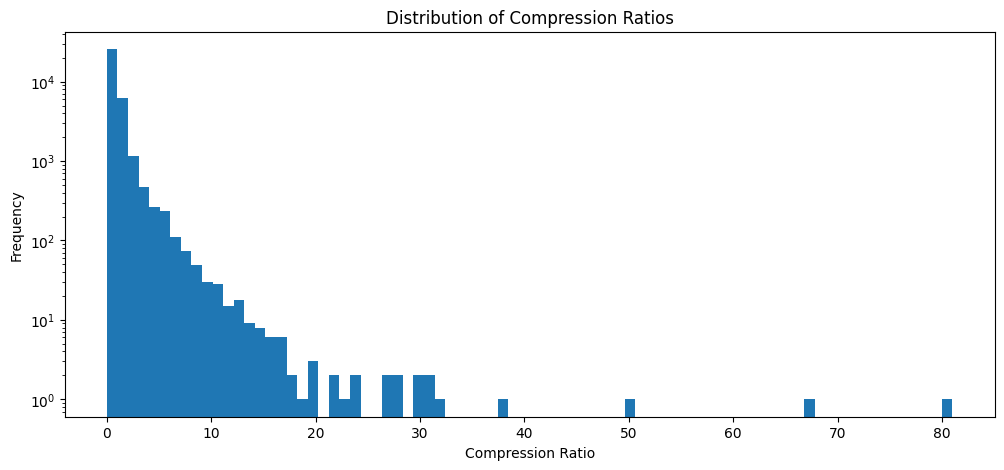

In [18]:
plt.figure(figsize=(12, 5))
plt.hist(df['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [19]:
largest = df.iloc[np.argmax(df["compression_ratio"])]
print(largest)
print(largest["input_text"])
print()
print(largest["target_text"])

title                                                           S.A.S.
input_text                                    SAS or Sas may refer to:
target_text          The S.A.S. or Special Air Service, is a Specia...
compression_ratio                                                 81.0
Name: 37696, dtype: object
SAS or Sas may refer to:

The S.A.S. or Special Air Service, is a Special Operations Organisation of the British Army. It was founded in 1941 to attack behind the German line of defence in North Africa, in World War II. They are one of the best schooled units in the world, that makes them very valuable. There are about 500 active SAS soldiers.
The SAS is a secret organisation. Its members often do not tell anyone except close family that they are in it. The British Ministry of Defence  rarely speaks of the SAS and mission details are never released until much later.
The badge of the organisation was originally designed as a flaming sword of Damocles but ended up as a winged dagger

In [20]:
df = df[(df["compression_ratio"] > 0.2) & (df["compression_ratio"] < 1.5)]

Articles titled "List of x things" on Wikipedia are not considered proper summarizations because they typically consist of enumerations rather than narrative content. These lists do not provide much context or detailed information to summarize.

In [21]:
df.drop(df[df["title"].str.contains("^List of", regex=True)].index, inplace=True)

In [25]:
df["summary_len"] = df["target_text"].apply(len)
threshold = df["summary_len"].quantile(0.95)
large_summaries = df[
    (len(df["target_text"]) > threshold) & (df["compression_ratio"] > 1.2)
]

In [26]:
large_summaries.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio,summary_len
37770,Prince Nakcheon,Prince Nakcheon was a royal family member of ...,Prince Nakcheon was a nobleman of the Joseon ...,1.498246,427
33043,İrsen Küçük,İrsen Küçük was a Turkish Cypriot politician ...,İrsen Küçük was a Turkish Cypriot politician....,1.497326,280
8982,"Tuttle, Oklahoma","Tuttle is a city in Grady County, Oklahoma, Un...",Tuttle is a city in Oklahoma in the United Sta...,1.496933,244
8389,Motorcycle,A motorcycle is a two or three-wheeled motor ...,A motorcycle is a vehicle used to transport p...,1.496833,1654
14840,Abecedarius,An abecedarius is a special type of acrostic ...,An abecedarius is an acrostic where the first ...,1.496732,229


In [27]:
len(large_summaries)

1955

In [34]:
sample = large_summaries.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([6020], dtype='int64')
Edmund Dantes Urick , known professionally as Ed Ames or Eddie Ames, was an American pop singer and actor. He was known for playing Mingo in the television series Daniel Boone, and for his Easy Listening number #1 hits of the mid-to-late 1960s including "My Cup Runneth Over", "Time, Time", and "When the Snow Is on the Roses". He was also part of the popular 1950s singing group with his siblings, the Ames Brothers.
----------------------------------------Target Text----------------------------------------
Ed Ames  was an American pop singer and actor. He was known for playing Mingo in the television series Daniel Boone and for his pop hits of the 1960s including "My Cup Runneth Over", "Who Will Answer?" and "When the Snow Is on the Roses". 
He was also part of the popular 1950s singing group with his siblings, The Ames Brothers. He was born in Malden, Massachusetts.
From 1968 until 1987, he also owned a percentage of the Phoenix Suns.
Ames died at his Los An

In [35]:
refer_to_articles = df["input_text"].str.contains(r"may refer to",
                                                  case=False,
                                                  regex=True)
df = df[~refer_to_articles]

In [36]:
df["compression_ratio"].describe()

,compression_ratio
count,24731.000000
mean,0.675694
std,0.336292
min,0.200095
25%,0.376177
50%,0.622356
75%,0.959054
max,1.498246


In [41]:
# minimum length thresholds
min_input_words = 10
min_target_words = 8

min_compression_ratio = 0.2
max_compression_ratio = 1.5


filtered_df = df[
    (df['input_text'].str.split().str.len() >= min_input_words) &
    (df['target_text'].str.split().str.len() >= min_target_words)
    & (df['compression_ratio'] >= min_compression_ratio) &
    (df['compression_ratio'] <= max_compression_ratio)
]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print(f"Removed entries: {len(df) - len(filtered_df)}")

Original dataset size: 24731
Filtered dataset size: 24574
Removed entries: 157


In [42]:
filtered_df.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio,summary_len
37770,Prince Nakcheon,Prince Nakcheon was a royal family member of ...,Prince Nakcheon was a nobleman of the Joseon ...,1.498246,427
33043,İrsen Küçük,İrsen Küçük was a Turkish Cypriot politician ...,İrsen Küçük was a Turkish Cypriot politician....,1.497326,280
8982,"Tuttle, Oklahoma","Tuttle is a city in Grady County, Oklahoma, Un...",Tuttle is a city in Oklahoma in the United Sta...,1.496933,244
8389,Motorcycle,A motorcycle is a two or three-wheeled motor ...,A motorcycle is a vehicle used to transport p...,1.496833,1654
14840,Abecedarius,An abecedarius is a special type of acrostic ...,An abecedarius is an acrostic where the first ...,1.496732,229


In [43]:
filtered_df.info()
print()
filtered_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 24574 entries, 0 to 38294
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              24574 non-null  object 
 1   input_text         24574 non-null  object 
 2   target_text        24574 non-null  object 
 3   compression_ratio  24574 non-null  float64
 4   summary_len        24574 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB



,compression_ratio,summary_len
count,24574.000000,24574.000000
mean,0.674162,368.196346
std,0.335603,347.378431
min,0.200095,39.000000
25%,0.375616,138.000000
50%,0.620909,271.000000
75%,0.955548,468.000000
max,1.498246,10260.000000


In [44]:
sample = filtered_df.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([3416], dtype='int64')
Daniel Woodson  was secretary of Kansas Territory  and a five-time acting governor of the territory.

----------------------------------------Target Text----------------------------------------
Daniel Woodson  was secretary of Kansas Territory  and a five-time acting governor of the territory.


In [45]:
filtered_df = filtered_df[
    ~(filtered_df['input_text'] == filtered_df['target_text'])
]

In [46]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24334 entries, 0 to 38294
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              24334 non-null  object 
 1   input_text         24334 non-null  object 
 2   target_text        24334 non-null  object 
 3   compression_ratio  24334 non-null  float64
 4   summary_len        24334 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [47]:
%pip install -q textstat rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.2 MB/s eta 0:00:00


In [48]:
from textstat import textstat
from rouge import Rouge

In [49]:
# calculate readability score
filtered_df['readability_score'] = filtered_df['target_text'].apply(
    textstat.flesch_reading_ease)

In [50]:
filtered_df.describe()

,compression_ratio,summary_len,readability_score
count,24334.000000,24334.00000,24334.000000
mean,0.670949,370.02289,57.503939
std,0.335682,348.18841,17.933357
min,0.200095,39.00000,-67.610000
25%,0.373464,139.00000,47.280000
50%,0.614582,273.00000,59.300000
75%,0.946077,470.00000,69.620000
max,1.498246,10260.00000,109.040000


In [51]:
# calculating ROUGE scores
rouge = Rouge()


def calculate_rouge(row):
    scores = rouge.get_scores(row['target_text'], row['input_text'])[0]
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']


filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
            ] = filtered_df.apply(calculate_rouge, axis=1, result_type='expand')

filtered_df.head()

,title,input_text,target_text,compression_ratio,summary_len,readability_score,rouge-1,rouge-2,rouge-l
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.824000,103,53.88,0.864865,0.756757,0.864865
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.214403,131,58.62,0.224719,0.051282,0.224719
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.700809,260,86.71,0.538462,0.333333,0.538462
3,Kamrieng District,Kamrieng is a district of Battambang provinc...,Kamrieng District is a district of Battamban...,1.120000,84,26.47,0.857143,0.631579,0.857143
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,49,68.77,0.465116,0.285714,0.465116


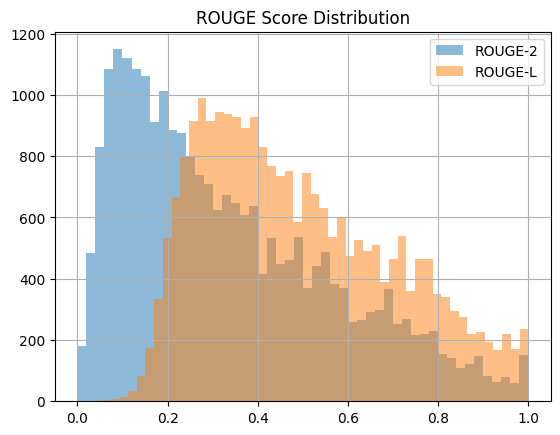

In [52]:
filtered_df['rouge-2'].hist(bins=50, alpha=0.5, label="ROUGE-2")
filtered_df['rouge-l'].hist(bins=50, alpha=0.5, label="ROUGE-L")
plt.legend()
plt.title("ROUGE Score Distribution")
plt.show()

In [53]:
min_readability_score = 40

filtered_df_readability = filtered_df[
    (filtered_df['readability_score'] >= min_readability_score)
]

In [55]:
filtered_df_readability.info()
filtered_df_readability

<class 'pandas.core.frame.DataFrame'>
Index: 20644 entries, 0 to 38292
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              20644 non-null  object 
 1   input_text         20644 non-null  object 
 2   target_text        20644 non-null  object 
 3   compression_ratio  20644 non-null  float64
 4   summary_len        20644 non-null  int64  
 5   readability_score  20644 non-null  float64
 6   rouge-1            20644 non-null  float64
 7   rouge-2            20644 non-null  float64
 8   rouge-l            20644 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.6+ MB


,title,input_text,target_text,compression_ratio,summary_len,readability_score,rouge-1,rouge-2,rouge-l
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.824000,103,53.88,0.864865,0.756757,0.864865
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.214403,131,58.62,0.224719,0.051282,0.224719
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.700809,260,86.71,0.538462,0.333333,0.538462
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,49,68.77,0.465116,0.285714,0.465116
8,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.574405,193,43.69,0.470588,0.303797,0.470588
...,...,...,...,...,...,...,...,...,...
38287,Texas Christian University,Texas Christian University is a private resea...,Texas Christian University is a private co-ed ...,0.201485,190,61.02,0.205882,0.116279,0.205882
38288,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.322799,143,67.76,0.297297,0.175824,0.270270
38290,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.410678,800,66.33,0.195440,0.050808,0.182410
38291,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,1.152381,121,69.79,0.814815,0.466667,0.666667


In [58]:
# filter based on ROUGE scores
min_rouge_2 = 0.2
max_rouge_2 = 0.6
min_rouge_l = 0.3
max_rouge_l = 0.8

print(f"Original dataset size: {len(filtered_df_readability)}")

filtered_df_rouge = filtered_df_readability[
    (filtered_df_readability['rouge-2'] >= min_rouge_2) &
    (filtered_df_readability['rouge-2'] <= max_rouge_2) &
    (filtered_df_readability['rouge-l'] >= min_rouge_l) &
    (filtered_df_readability['rouge-l'] <= max_rouge_l)
]

print(f"Filtered dataset size: {len(filtered_df_rouge)}")
# do da math

Original dataset size: 20644
Filtered dataset size: 9869


quality or quantity tradeoff

In [67]:
sample = filtered_df_rouge.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([5241], dtype='int64')
Stephen Michael Gleason  is an American former professional football player who played as a safety with the New Orleans Saints of the National Football League . He played college football for the Washington State Cougars. Originally signed by the Indianapolis Colts as an undrafted free agent in 2000, he played for the Saints through the 2006 season. As a free agent in 2008, Gleason retired from the NFL after eight seasons.
Gleason is particularly known for his block of a punt early in a 2006 game, which became a symbol of recovery in New Orleans in the team's first home game after Hurricane Katrina.
In 2011, Gleason revealed that he was battling amyotrophic lateral sclerosis . His experiences while living with the disease were captured on video over the course of a five-year period and featured in the 2016 documentary Gleason.
He was awarded a Congressional Gold Medal in 2019 and the Arthur Ashe Courage Award in 2024 for his contributions to ALS awareness.


In [68]:
filtered_df_rouge.to_json("data.jsonl", orient="records", lines=True)

In [69]:
df = pd.read_json("data.jsonl", lines=True)

In [70]:
df

,title,input_text,target_text,compression_ratio,summary_len,readability_score,rouge-1,rouge-2,rouge-l
0,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.700809,260,86.71,0.538462,0.333333,0.538462
1,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,49,68.77,0.465116,0.285714,0.465116
2,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.574405,193,43.69,0.470588,0.303797,0.470588
3,Arkhangelsk Oblast,Arkhangelsk Oblast is a federal subject of Ru...,Arkhangelsk Oblast is one of the federal subj...,0.548577,559,50.12,0.483660,0.270270,0.483660
4,Fred Kida,Fred Kida was a Japanese-American comic boo...,Fred Kida was a Japanese-American comic book...,0.504026,313,57.27,0.554622,0.418301,0.554622
...,...,...,...,...,...,...,...,...,...
9864,Steffen Hofmann,Steffen Hofmann is a German football coach an...,Steffen Hofmann is a former German football p...,1.348018,306,68.97,0.500000,0.224719,0.447368
9865,That Evening Sun (movie),That Evening Sun is a 2009 American drama film...,That Evening Sun is a 2009 movie based on a 20...,0.395000,395,65.73,0.462428,0.320000,0.462428
9866,Nomain,Nomain is a commune in the Nord department in...,Nomain is a commune in Nord in north France. I...,1.253968,79,97.70,0.583333,0.333333,0.583333
9867,Grand Duchess Xenia Alexandrovna of Russia,Grand Duchess Xenia Alexandrovna of Russia wa...,Grand Duchess Xenia Alexandrovna of Russia wa...,0.421241,353,56.76,0.432836,0.225989,0.417910
